# TSmask: Time series cloud and cloud shadow detection for Sentinel-2 <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2_tsmask](https://explorer.dea.ga.gov.au/s2_tsmask),
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)


## Background

Remote sensing images play more and more important roles in a lot of applications. 
Such applications and other remote sensing activities depend on noise free remote sensing data. 
Beside sensor abnormality, clouds and clouds shadow pose significant challenges to obtaining the desired results. 
Detecting cloud and cloud shadow pixels and removing them from inputs for remote sensing data is essential for all remote sensing data modelling algorithms.

**TSmask** is a time series cloud and cloud shadow detection algorithm for Sentinel-2 surface reflectance data. 
`TSmask` models time series of surface reflectance derived indices and calculates time series abnormality coefficients for pixels in the time series. 
`TSmask` does not rely on predefined training data to generate complex models with many rule sets, which often work well for data similar to the training data while return poor results for data contrasting to the training data. 
Instead, `TSmask` identifies cloud and cloud shadows by detecting local abnormalities in temporal and spatial contexts from abnormality coefficients.

The `TSmask` analysis algorithm classifies each Sentinel-2 pixel into one of four distinctive categories:

* 0 = No observation
* 1 = Clear
* 2 = Cloud
* 3 = Cloud shadow

## Description

This notebook demonstrates how to:

1. Load `TSmask` data from the `s2_tsmask` product
2. Load a matching time series from the default Sentinel-2 `fmask` band
3. Inspect the classification flags available in both datasets
4. Compare cloudy pixel counts from both datasets to assess how well each dataset classifies cloud
5. Compare cloud shadow pixel counts from both datasets to assess how well each dataset classifies cloud shadow
6. Apply a cloud and cloud shadow mask to RGB Sentinel-2 data and generate a simple composite based on both `TSmask` and `fmask` classifications

---


## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline

import sys
import datacube
import xarray as xr
from odc.ui import with_ui_cbk
import matplotlib.pyplot as plt
from datacube.storage.masking import make_mask

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_plotting import display_map

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='TSmask')

## Inspect the TSmask product
`TSmask` is available in DEA in a product called `s2_tsmask`. 
We can inspect its features using `.list_measurements()`:

In [3]:
dc.list_measurements().loc['s2_tsmask']

,name,dtype,units,nodata,aliases,flags_definition,spectral_definition
measurement,,,,,,,
classification,classification,uint8,1,0,NaN,"{'classification': {'bits': [0, 1, 2, 3, 4, 5,...",NaN


## Load in matching TSmask and fmask data

To compare results from `TSmask` with the default `fmask` cloud mask that is packaged with Sentinel 2 data, we can load matching data from both datasets from the datacube for the same sample location.
In this example, we will use the urban area of Canberra:


In [4]:
# Set up query
query = {
    'y': (-35.28, -35.34),
    'x': (149.12, 149.18),
    'time': ('2018-01', '2018-03'),
    'output_crs': 'EPSG:3577',
    'resolution': (-20, 20)
}

# Preview sample location
display_map(x=query['x'], y=query['y'])

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

We now load data from both datasets.

Unlike Sentinel 2 ARD data which is provided in seperate products for Sentinel-2A and 2B, the `s2_tsmask` product is provided as a single dataset that includes classifications for both Sentinel-2A and 2B. 
Because of this, it can be useful to concatenate Sentinel-2 ARD data into a single combined dataset for subsequent analyses.

> **Note:** This step can take several minutes to complete; please be patient. 

In [5]:
# Load in temporal cloudmask data
tsmask_ds = dc.load(product='s2_tsmask', 
                    progress_cbk=with_ui_cbk(),
                    **query)

# Load in Sentinel-2A and 2B data including fmask cloud masking band
s2a_ds = dc.load(
    product='s2a_ard_granule',
    measurements=['fmask', 'nbart_red', 'nbart_green', 'nbart_blue'],
    progress_cbk=with_ui_cbk(),
    **query)

s2b_ds = dc.load(
    product='s2b_ard_granule',
    measurements=['fmask', 'nbart_red', 'nbart_green', 'nbart_blue'],
    progress_cbk=with_ui_cbk(),
    **query)

# Combine Sentinel-2A and 2B data into a single dataset
s2_ds = xr.concat([s2a_ds, s2b_ds], dim='time').sortby('time')

Once the data has loaded, we can print the output `tsmask_ds` object to preview the dataset.
The dataset has a single band `classification` which contains the cloud and cloud shadow masking data:


In [6]:
# Print the output TSMask data
print(tsmask_ds)

<xarray.Dataset>
Dimensions:         (time: 18, x: 316, y: 368)
Coordinates:
  * time            (time) datetime64[ns] 2018-01-05T00:02:29.027000 ... 2018-03-31T00:02:41.026000
  * y               (y) float64 -3.957e+06 -3.957e+06 ... -3.965e+06 -3.965e+06
  * x               (x) float64 1.549e+06 1.549e+06 ... 1.555e+06 1.555e+06
Data variables:
    classification  (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 2 2 2 2 2 2 2 2
Attributes:
    crs:      EPSG:3577


### Optional: restrict comparison only to observations in both datasets

Due to differences in the processing pipelines used to generate Sentinel-2 ARD data and `TSmask`, there may be a different number of observations returned for both of these datasets. 
The following step can be useful for ensuring that both datasets contain exactly the same observations:

In [7]:
# Return only observations that have timesteps in both datasets
matching_times = (tsmask_ds.time - s2_ds.time).time
tsmask_ds = tsmask_ds.sel(time=matching_times)
s2_ds = s2_ds.sel(time=matching_times)

### Inspect TSmask bit flags
The `classification` band contains flag information that classifies each pixel into no data, valid, cloudy and cloud shadowed observations:

In [8]:
# Print temporal cloudmask flags
tsmask_ds.classification.flags_definition

{'classification': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'nodata', '1': 'valid', '2': 'cloud', '3': 'shadow'},
  'description': 'TSmask classification'}}

The default Sentinel 2 `fmask` cloud mask contains the same flags:

In [9]:
# Print Sentinel 2 fmask flags
s2_ds.fmask.flags_definition

{'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'nodata',
   '1': 'valid',
   '2': 'cloud',
   '3': 'shadow',
   '4': 'snow',
   '5': 'water'},
  'description': 'Fmask'}}

## Comparing TSmask and fmask

### Compare cloud counts in both datasets

To compare classifications generated by `TSmask` against the default Sentinel 2 `fmask` classification, we can create a mask using the `make_mask` function from `datacube.storage.masking` and sum up all of the times a pixel was flagged as cloud in both datasets.

To make it easier to plot, we concatenate both of these summed datasets into a single combined dataset:

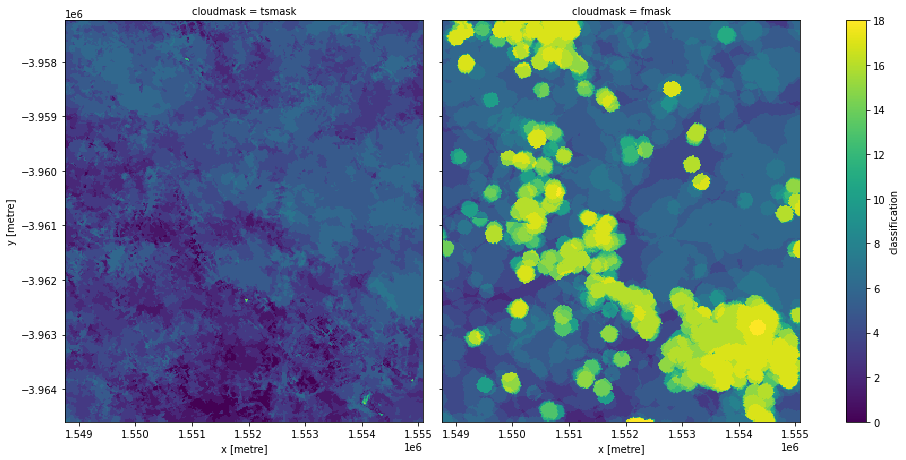

In [10]:
# TSmask and fmask cloud masks
tsmask_cloud = make_mask(tsmask_ds.classification, classification="cloud")
fmask_cloud = make_mask(s2_ds.fmask, fmask="cloud")

# Sum all cloudy pixels
tsmask_cloud_sum = tsmask_cloud.sum(dim='time')
fmask_cloud_sum = fmask_cloud.sum(dim='time')

# Combine into a single dataset and plot
combined_ds = xr.concat([tsmask_cloud_sum, fmask_cloud_sum], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot(col='cloudmask', size=6.5, aspect=1)

### Compare cloud shadow counts in both datasets

In a similar way, we can compare cloud shadow counts in both datasets:

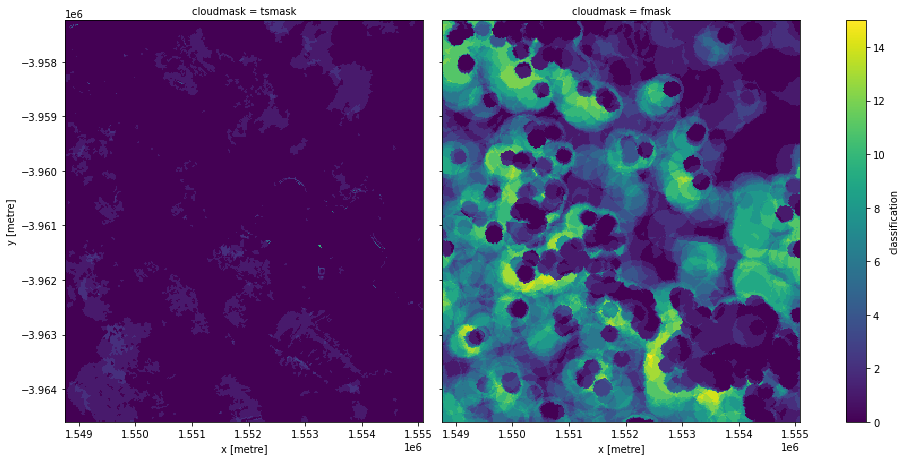

In [11]:
# TSmask and fmask cloud masks
tsmask_shadow = make_mask(tsmask_ds.classification,
                          classification="shadow")
fmask_shadow = make_mask(s2_ds.fmask, fmask="shadow")

# Sum all cloudy pixels
tsmask_shadow_sum = tsmask_shadow.sum(dim='time')
fmask_shadow_sum = fmask_shadow.sum(dim='time')

# Combine into a single dataset and plot
combined_ds = xr.concat([tsmask_shadow_sum, fmask_shadow_sum], dim='cloudmask')
combined_ds = combined_ds.assign_coords(cloudmask=['tsmask', 'fmask'])
combined_ds.plot(col='cloudmask', size=6.5, aspect=1)

## Produce cloud free composites from TSmask and fmask

For a final comparison of both classifications, we can generate a cloud free composite image by masking our Sentinel-2 satellite bands with `TSmask` and `fmask` cloud and cloud shadow masks.

First, we generate a mask that will have a `True` value for any pixel that includes valid data.
Because `fmask` has an additional `water` and `snow` flags, we need to include these to generate a comparable mask.

> **Note:** For this example we will generate a simple mean composite of each of the red, green and blue Sentinel-2 bands to highlight areas where clouds were poorly removed from the dataset.
For a more statistically reliable compositing method, refer to the [Generating geometric median composites (geomedians)](../Frequently_used_code/Geomedian_composites.ipynb) notebook.

/env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


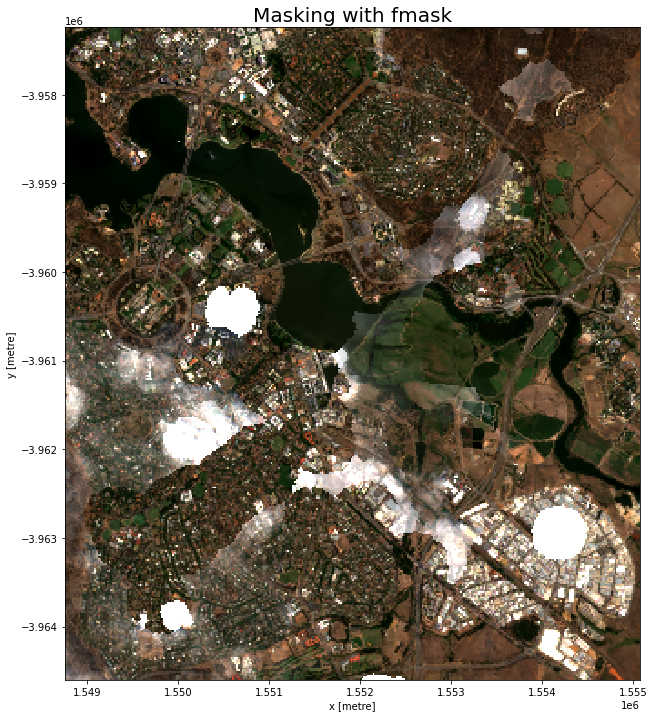

In [12]:
# Identify pixels that are either "valid", "water" or "snow"
cloud_free_mask = (make_mask(s2_ds.fmask, fmask="valid") |
                   make_mask(s2_ds.fmask, fmask="water") |
                   make_mask(s2_ds.fmask, fmask="snow"))

# Apply mask to RGB bands
s2_masked = s2_ds[['nbart_red', 'nbart_green',
                   'nbart_blue']].where(cloud_free_mask)

# Generate mean composite
s2_mean = s2_masked.mean(dim='time')

# Plot in RGB
rgb(s2_mean, size=12)
plt.title('Masking with fmask', fontdict={'fontsize': 20});

Observe that the `fmask`-masked data contains several data gaps (bright white pixels) where urban areas are concistently mapped as cloud, and patchy areas of cloud and cloud shadow that was not captured in by `fmask`.

Now we can plot the same data with a mask generated from `TSmask` applied instead of `fmask`. 
Note that compared to the example above, the composite is clean and free of cloud or shadow, indicating that classification did a better job of removing these sources of noise from the time series. 

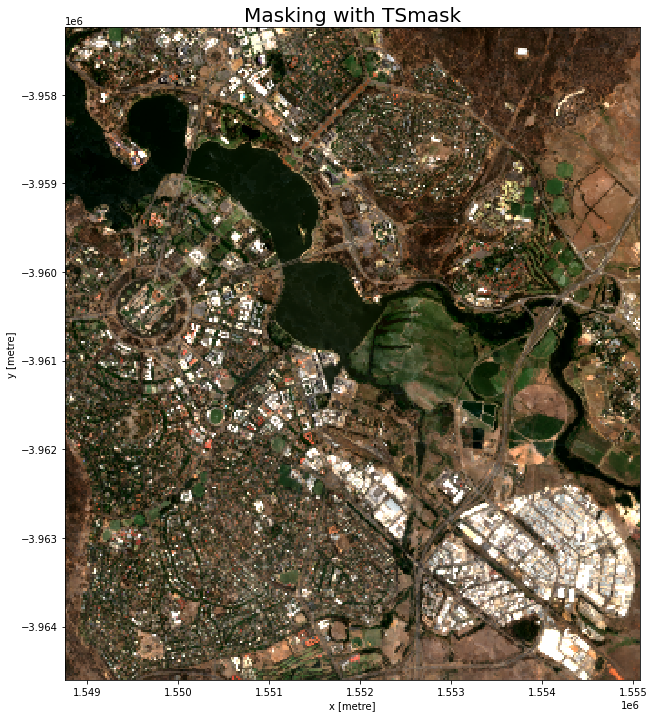

In [13]:
# Identify pixels that are "Clear"
cloud_free_mask = make_mask(tsmask_ds.classification, classification="valid")

# Apply mask to RGB bands
s2_masked = s2_ds[['nbart_red', 'nbart_green',
                   'nbart_blue']].where(cloud_free_mask)

# Generate mean composite
s2_mean = s2_masked.mean(dim='time')

# Plot in RGB
rgb(s2_mean, size=12)
plt.title('Masking with TSmask', fontdict={'fontsize': 20});

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.7+262.g1cf3cea8


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)